> Это пример решения данной задачи с использованием Keras. Вы можете использовать этот кернал для дальнейших своих исследований и эксперементов.
# Car classification
![](http://img1.joyreactor.cc/pics/post/автопром-ваз-лимузин-ватермарк-351083.jpeg)

### Основная идея - берем предобученую на imagenet сеть Xception и дообучаем под нашу задачу.
По ходу кернела я буду давать комментарии и подсказки (где что можно подкрутить и что можно еще попробовать, чтоб улучшить скор).  
Многие параметры специально установлены не оптимальным образом ;)

Удачи и Поехали!

In [23]:
!pip show keras

Name: keras
Version: 2.6.0
Summary: TensorFlow Keras.
Home-page: https://keras.io/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: 
Required-by: tensorflow


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv
import os

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.callbacks import Callback
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model
from keras.utils import np_utils
from keras.applications.xception import Xception
from keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']


In [25]:
! unzip -q ../input/test.zip -d ../working/test
! unzip -q ../input/train.zip -d ../working/train

replace ../working/test/test_upload/97344.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
replace ../working/train/train/0/100155.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Setup

In [26]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 10
BATCH_SIZE           = 64
LR                   = 1e-4

CLASS_NUM            = 10
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
IMAGE_PATH = '../working/train/'
TEST_IMAGE_PATH = '../working/test/'
PATH = "../working/car/"

In [27]:
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

#from tensorflow import set_random_seed
import tensorflow
tensorflow.random.set_seed(RANDOM_SEED)

FileExistsError: [Errno 17] File exists: '../working/car/'

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

In [ ]:
train_df.info()

In [ ]:
train_df.Category.value_counts()

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(IMAGE_PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
image = PIL.Image.open(IMAGE_PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

### Уже догадался что означают классы?
### Тогда перейдем к подготовке данных...
![](http://admem.ru/content/images/1391000424.jpg)

# Data

### Data augmentation

In [28]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)
# Поиграйся тут параметрами чтоб понять что к чему. 
# Официальная дока https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Задание для Про - попробуй подключить сторонние более продвинутые библиотеки аугминтации изображений

### datagen

In [29]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_directory(
    IMAGE_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    IMAGE_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=TEST_IMAGE_PATH+'test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# кстати, ты заметил, что для сабмишена мы используем другой источник для генератора flow_from_dataframe? 
# Как ты думаешь, почему?

Found 14009 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.
Found 6675 validated image filenames.


# Model

### подгружаем предобученую сеть Xception

In [ ]:
input_shape

In [30]:
# Кстати Попробуй еще другие архитектуры сетей...
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [31]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
base_model.trainable = False

In [32]:
# Устанавливаем новую "голову"
# Тут тоже можно поиграться, попробуй добавить Batch Normalization например.

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

## Fit

In [34]:
# Рекомендую добавить еще функции из https://keras.io/callbacks/
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max')
#earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
callbacks_list = [checkpoint]

# Для про - попробуй добавить разные техники управления Learning Rate
# Например:
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
# http://teleported.in/posts/cyclic-learning-rate/

In [35]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# попробуй применить transfer learning с fine-tuning
# Сначала замораживаем все слои кроме новой "головы"
# Потом, когда мы научили последние слои (голову) под новую задачу, можно разморозить все слои и пройтись маленьким лернинг рейтом

Epoch 1/10
219/219 [==============================] - 301s 1s/step - loss: 0.8519 - accuracy: 0.7025 - val_loss: 0.3128 - val_accuracy: 0.8911

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
219/219 [==============================] - 289s 1s/step - loss: 0.2024 - accuracy: 0.9288 - val_loss: 0.2859 - val_accuracy: 0.9008

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
219/219 [==============================] - 289s 1s/step - loss: 0.1186 - accuracy: 0.9567 - val_loss: 0.2151 - val_accuracy: 0.9220

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
219/219 [==============================] - 288s 1s/step - loss: 0.0784 - accuracy: 0.9709 - val_loss: 0.2453 - val_accuracy: 0.9272

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
219/219 [==============================] - 288s 1s/step - loss: 0.0601 - accuracy: 0.9779 - val_loss: 0.2184 - val_accuracy: 0.9317

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
219/219 [==============================] - 2

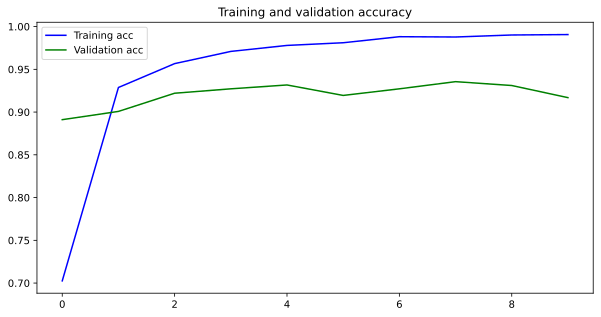

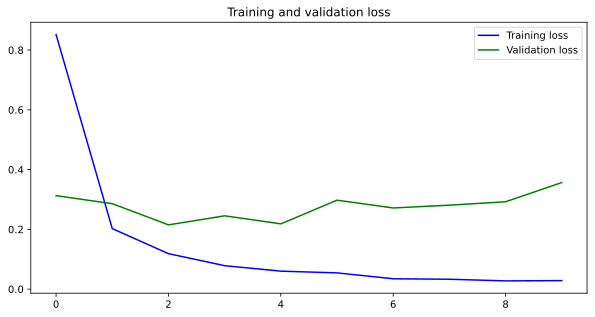

In [36]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

In [37]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [39]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

25/25 [==============================] - 25s 975ms/step - loss: 0.3652 - accuracy: 0.9137
Accuracy: 91.37%


# Submission

In [40]:
test_sub_generator.samples

6675

In [42]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

105/105 [==============================] - 42s 398ms/step


In [43]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Для Про - попробуй TTA

Save submit


In [44]:
submission.head()

,Id,Category
0,305108.jpg,2
1,295075.jpg,0
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


## Интересно, к какому классу модель отнесет вот этот авто:
![](http://kvu.su/upload/iblock/e3a/e3a32ed064fd71e4ce99b7f57d2de745.jpg)